# Interpolating spatial data using `xr_interpolate` <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Spatial datasets often vary in spatial coverage, making it challenging to compare values at specific locations or points against more continuous data collected by Earth Observation satellites.

Spatial interpolation is a fundamental spatial analysis technique that involves estimating the values of a variable at unsampled locations within an area covered by sparse or unevenly distributed observations. 
Interpolation can be used to help to fill gaps between these observations, offering a more complete and continuous picture of environmental variables such as temperature, precipitation, vegetation indices, and soil moisture.
This allows spatial data to be more easily compared against data collected by satellites, potentially enabling more meaningful insights into the influence of environmental processes across the landscape.


## Description
In this example we will demonstrate how to perform a range of useful spatial interpolation techniques using the `xr_interpolate` function from `dea_tools.spatial`:

1. [Load point data to interpolate](#Loading-spatial-points)
2. [Load satellite data for an area of interest](#Loading-satellite-data)
3. [Spatially interpolate points into the extent of the satellite data using](#Interpolation-with-xr_interpolate):
    * "nearest" neighbour interpolation
    * "linear" interpolation
    * "idw" Inverse Distance Weighted interpolation (with custom `p`, `k` and `max_dist`)
    * "rbf" Radial Basis Function interpolation


***

## Getting started

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
import odc.geo.xr
import geopandas as gpd
import matplotlib.pyplot as plt

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.spatial import xr_interpolate
from dea_tools.datahandling import load_ard

### Connect to the datacube

Connect to the datacube so we can access DEA data:

In [2]:
dc = datacube.Datacube(app="Interpolation")

## Loading data

### Loading spatial points

We can load the example spatial points we would like to interpolate.
This points dataset contains a variable of interest "z" that we wish to interpolate into every pixel in our study area:

<Axes: >

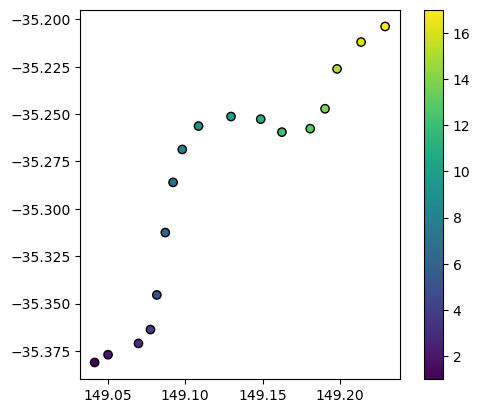

In [3]:
points_gdf = gpd.read_file(
    "../Supplementary_data/Interpolation/interpolation_points.geojson"
)
points_gdf.plot(column="z", edgecolor="black", legend=True)

### Loading satellite data
We can also load some satellite data to provide the pixels into which we want to interpolate our points. 
In this example, we will load data over Canberra, Australia:

In [4]:
# Parliament House, Canberra
query = {
    "x": (149.04, 149.23),
    "y": (-35.20, -35.38),
    "time": ("2020-05-07"),
}

# Load satellite data
ds = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red"],
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 1 time steps


We can now plot both our datasets onto the same map, to make sure they overlap. 


Note that we need to first reproject our points data to make sure it has the same coordinate reference system (CRS) as our satellite dataset.

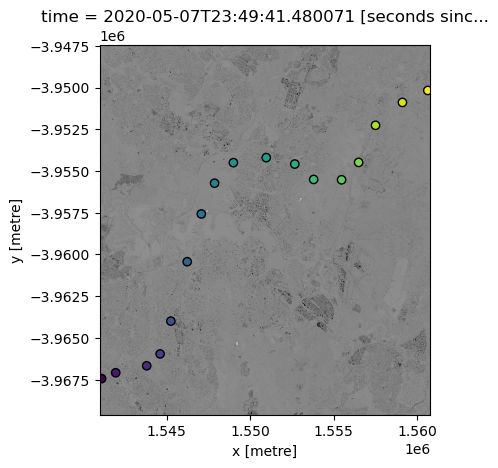

In [5]:
# Reproject points
points_gdf = points_gdf.to_crs(ds.odc.crs)

ds.nbart_red.plot(add_colorbar=False, cmap="Greys")
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

## Interpolation with `xr_interpolate`

### Nearest neighbour interpolation

We can now use the `xr_interpolate` function to interpolate our variable of interest "z" from `points_gdf` into the spatial extent and pixels of our satellite data `ds`.

Firstly, we will use the simplest interpolation method: "nearest".
This sets every pixel in `ds` to the value of the nearest point in `points_gdf`:

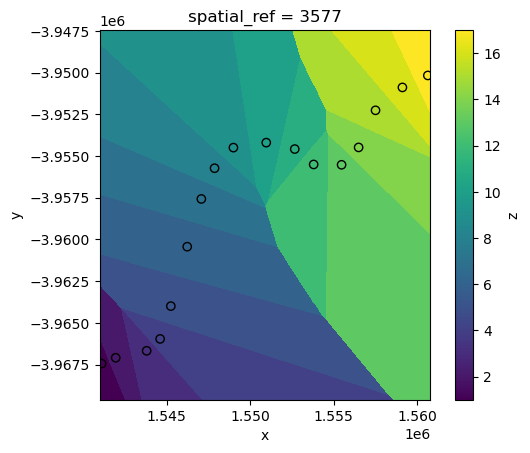

In [6]:
# Run interpolation
interp_nearest = xr_interpolate(ds=ds, gdf=points_gdf, method="nearest")

# Plot input points over the interpolated surface
interp_nearest.z.plot()
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

### Linear interpolation

Another common interpolation method is "linear" interpolation. 
Linear interpolation works by estimating values at unsampled locations based on the assumption that the change between known data points is linear, effectively creating a smooth transition across the spatial surface.

However, a limitation of this method is that it can only predict values within the minimum bounding box of our points data:

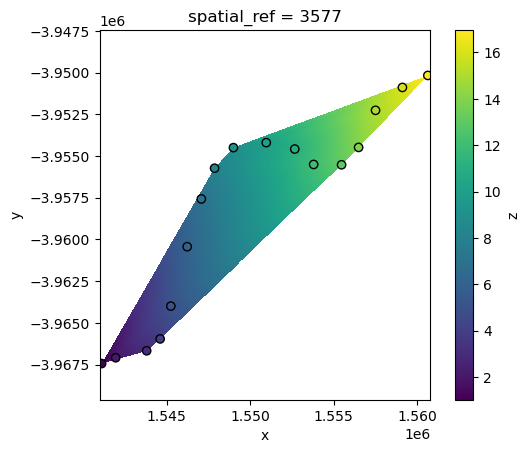

In [7]:
# Run interpolation
interp_linear = xr_interpolate(ds=ds, gdf=points_gdf, method="linear")

# Plot input points over the interpolated surface
interp_linear.z.plot()
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

### Inverse Distance Weighted interpolation

Inverse Distance Weighting ("idw") interpolation is another method that works by estimating unknown values at unsampled locations using a weighted average of known data points, where closer points have a greater influence on the estimated values than those further away.

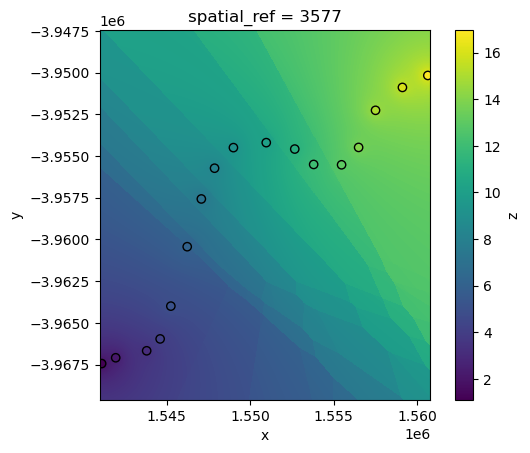

In [8]:
# Run interpolation
interp_idw = xr_interpolate(ds=ds, gdf=points_gdf, method="idw")

# Plot input points over the interpolated surface
interp_idw.z.plot()
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

The rate at which distant points influence the interpolation can be controlled via the `p` power function parameter.
Higher values of `p` will cause weightings for distant points to decrease rapidly, resulting in nearby points having more influence on predictions:


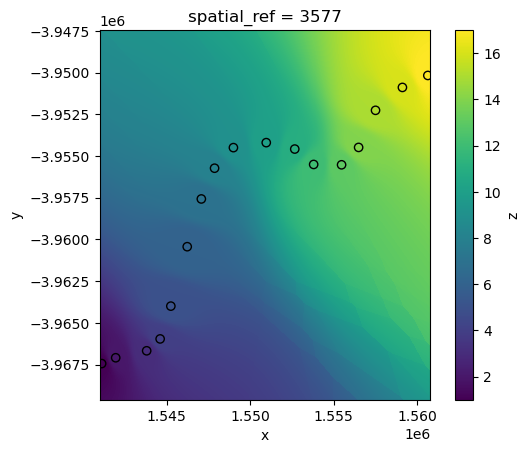

In [9]:
# Run interpolation
interp_idw_p5 = xr_interpolate(ds=ds, gdf=points_gdf, method="idw", p=5)

# Plot input points over the interpolated surface
interp_idw_p5.z.plot()
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

By default, `xr_interpolate` will calculate IDW using the nearest 10 neighouring points to any pixel.
However, the number of neighbouring points used in the calculation can be customised by passing a custom `k` value.

For example, by passing `k=1` we can produce a similar result to our previous "nearest" neighbour interpolation:

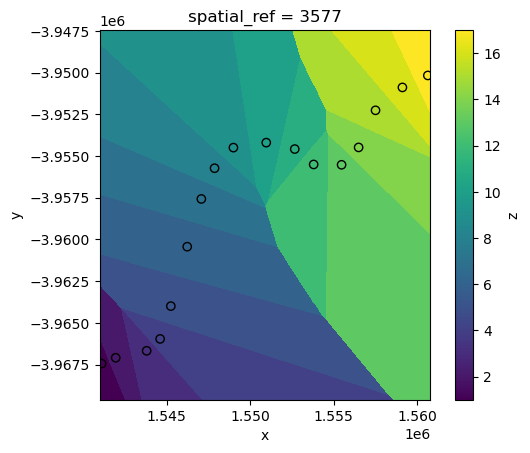

In [10]:
# Run interpolation
interp_idw_k1 = xr_interpolate(ds=ds, gdf=points_gdf, method="idw", k=1)

# Plot input points over the interpolated surface
interp_idw_k1.z.plot()
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

While higher values of `k` can produce smoother (but more generalised) results:

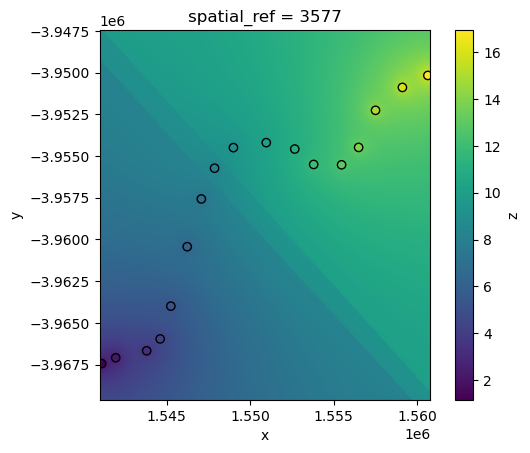

In [11]:
# Run interpolation
interp_idw_k15 = xr_interpolate(ds=ds, gdf=points_gdf, method="idw", k=15)

# Plot input points over the interpolated surface
interp_idw_k15.z.plot()
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

IDW interpolation also supports restricting interpolation to points located within a certain distance of each pixel using the `max_dist` parameter.

For example, we can include only points located within 3 km of each pixel in the IDW calculation:


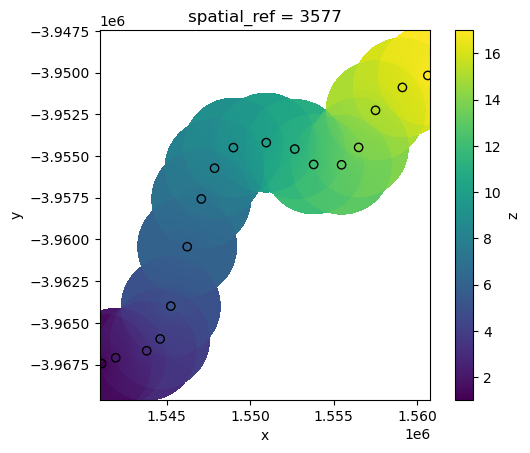

In [12]:
# Run interpolation
interp_idw_maxdist = xr_interpolate(ds=ds, gdf=points_gdf, method="idw", max_dist=3000)

# Plot input points over the interpolated surface 
interp_idw_maxdist.z.plot()
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

### Radial Basis Function interpolation

Radial Basis Function ("rbf") interpolation also works by estimating unknown values at unsampled locations using a weighted sum of known data points, with weights determined by a radial basis function that decreases with distance, ensuring a smooth and continuous surface.

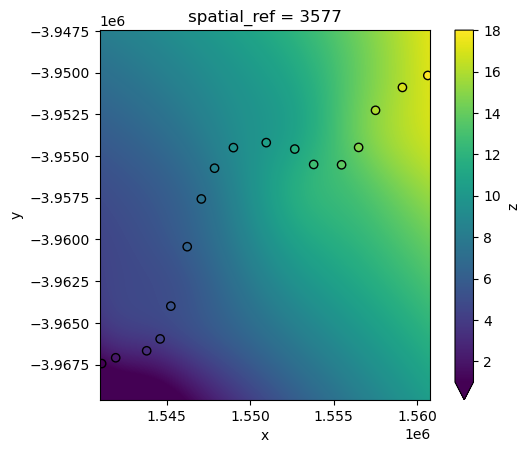

In [13]:
# Run interpolation
interp_idw_rbf = xr_interpolate(ds=ds, gdf=points_gdf, method="rbf")

# Plot input points over the interpolated surface 
interp_idw_rbf.z.plot(cmap="viridis", vmin=1, vmax=18)
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

RBF interpolation can be slow for large datasets, however.
To improve performance, use the `factor` parameter to calculate the interpolation on a lower resolution version of the satellite data pixels first (e.g. `factor=10` = 10 times lower resolution), then up-sample this to the original higher resolution as a final step.

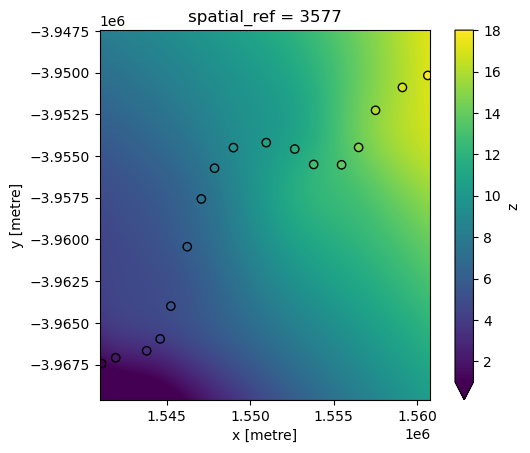

In [14]:
# Run interpolation
interp_idw_rbf = xr_interpolate(ds=ds, gdf=points_gdf, method="rbf", factor=10)

# Plot input points over the interpolated surface 
interp_idw_rbf.z.plot(cmap="viridis", vmin=1, vmax=18)
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black");

## Combining interpolated data with satellite data

Now that we have spatially interpolated our points into the same pixels as our satellite dataset, we can more easily use the data for analysis.

For example, we could extract areas of satellite pixels where our interpolated variable of interest "z" is likely to be greater than 10:

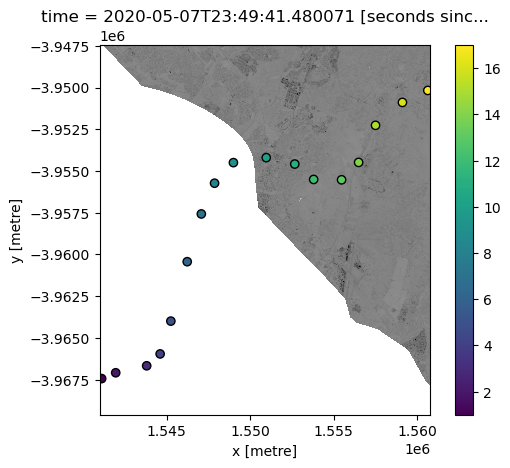

In [15]:
ds.nbart_red.where(interp_idw.z > 10).plot(add_colorbar=False, cmap="Greys")
points_gdf.plot(ax=plt.gca(), column="z", edgecolor="black", legend=True);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2024

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.18


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->